# Changepoint detection with delayed samples

This notebooks explores a maximum likelihood approach to changepoint detection and then examines an approach to try to detect changepoints when the individual samples could have been delayed. The samples could represent a count of the number of events on a given day, but that operational sensitivities mean that the observed day of a sample might be delayed from when it occurred. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy

from scipy import stats
from sklearn import metrics
from tqdm import tqdm

## Changepoint detection without delays

In [2]:
def generate_changepoint_data(n: int, a: float, b: float, p: float):
    """Generate data with n points that may contain a changepoint."""

    assert n > 3
    assert 0 < a < b
    assert 0 <= p <= 1

    # Means of the Poisson distributions
    lambda0 = np.random.uniform(low=a, high=b)
    lambda1 = np.random.uniform(low=a, high=b)

    # Samples from the two Poisson distributions
    x0 = np.random.poisson(lam=lambda0, size=n)
    x1 = np.random.poisson(lam=lambda1, size=n)

    # Is there a single changepoint?
    one_changepoint = np.random.uniform() < p

    if not one_changepoint:
        return {
            "samples": x0,
            "number_of_changepoints": 0,
            "position": None,
            "lambda": lambda0,
        }
    
    changepoint_position = np.random.randint(1, n-1)
    x = np.zeros(n)
    x[:changepoint_position] = x0[:changepoint_position]
    x[changepoint_position:] = x1[changepoint_position:]

    return {
        "samples": x,
        "number_of_changepoints": 1,
        "position": changepoint_position,
        "lambda0": lambda0,
        "lambda1": lambda1
    }

In [3]:
# Generate some random data
data = generate_changepoint_data(100, 2, 10, 0.5)
data

{'samples': array([ 8.,  5.,  3.,  8.,  3.,  5.,  7.,  4.,  2.,  5.,  2.,  3.,  2.,
         4.,  3.,  3.,  8.,  1.,  4.,  4.,  2.,  7.,  3.,  9.,  8.,  4.,
         5.,  0.,  2.,  6.,  7.,  8.,  2., 10.,  3.,  4.,  8.,  5.,  6.,
         3.,  7.,  4.,  5.,  5.,  7.,  3.,  6.,  5.,  4.,  5.,  2.,  8.,
         2.,  9.,  8.,  4.,  4.,  3.,  5.,  5.,  3., 10.,  4.,  6.,  3.,
         6.,  6.,  4.,  7.,  8.,  8.,  2.,  5.,  2.,  3.,  1.,  9.,  5.,
         5.,  8.,  6.,  1.,  7.,  9., 11., 11., 15.,  3., 11.,  6.,  2.,
         7., 14.,  6.,  7.,  9.,  6.,  1.,  5.,  5.]),
 'number_of_changepoints': 1,
 'position': 81,
 'lambda0': 4.894156805588856,
 'lambda1': 7.466930261029033}

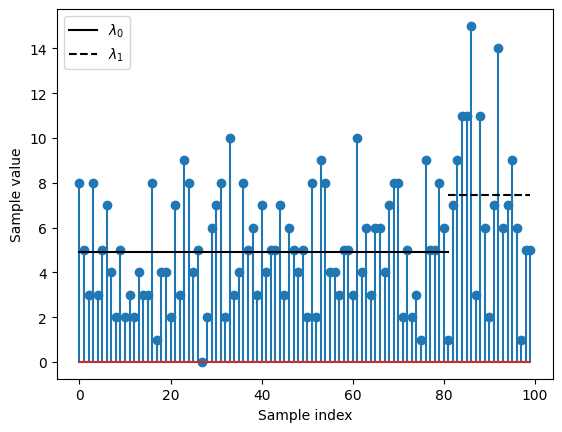

In [4]:
n = len(data['samples'])
plt.stem(data['samples'])

if data['number_of_changepoints'] == 0:
    plt.plot(np.arange(0, n), data['lambda'] * np.ones(n), '--k', label='$\\lambda$')
else:
    plt.plot(np.arange(0, data['position']+1), data['lambda0'] * np.ones(data['position']+1), '-k', label='$\\lambda_0$')
    plt.plot(np.arange(data['position'], n), data['lambda1'] * np.ones(n - data['position']), '--k', label='$\\lambda_1$')

plt.xlabel('Sample index')
plt.ylabel('Sample value')
plt.legend()
plt.show()

The likelihood of $N$ samples drawn from a Poisson distribution is given by

$$
p(x | \lambda) = \prod_{i=0}^{N-1} p(x_i | \lambda)
$$

where $\lambda$ is the mean of the Poisson distribution. The log likelihood of the samples $x$ is given by

$$
\ln p(x | \lambda) = \sum_{i=0}^{N-1} \ln p(x_i | \lambda).
$$

In [5]:
def log_likelihood_no_changepoints(x) -> float:
    """Log likelihood of the samples x assuming no changepoints."""

    # Estimate lambda using a MLE approach
    lam = np.mean(x)

    return np.sum([np.log(stats.poisson.pmf(xi, mu=lam)) for xi in x])

Suppose there is a changepoint at index $j$, then the likelihood of the samples is given by

$$
p(x | j, \lambda_0, \lambda_1) = \prod_{i=0}^{j-1} p(x_i | \lambda_0) \prod_{i=j}^{N-1} p(x_i | \lambda_1)
$$

where $\lambda_0$ is the mean of the Poisson distribution before the changepoint and $\lambda_1$ is the mean after. The log likelihood of the samples is given by

$$
\ln p(x | j, \lambda_0, \lambda_1) = \sum_{i=0}^{j-1} p(x_i | \lambda_0) + \sum_{i=j}^{N-1} p(x_i | \lambda_1).
$$

In [6]:
def log_likelihood_one_changepoint(x, j):
    """Log likelihood of the samples x with a changepoint at index j."""

    # Estimate lambda either side of the changepoint
    lambda0 = np.mean(x[:j])
    lambda1 = np.mean(x[j:])

    # Log likelihood of samples before the changepoint
    ll0 = np.sum([np.log(stats.poisson.pmf(xi, mu=lambda0)) for xi in x[:j]])
    
    # Log likelihood of samples after the changepoint
    ll1 = np.sum([np.log(stats.poisson.pmf(xi, mu=lambda1)) for xi in x[j:]])

    return ll0 + ll1

From a maximum likelihood perspective, the simplest way to find the index of the changepoint $j$ is to try every possible changepoint position and find which position maximises the log likelihood of the samples.

In [7]:
def find_most_likely_changepoint(x):
    """Find the changepoint position that maximises the log likelihood."""

    # Calculate the log likelihoods at each potential changepoint position
    n = len(x)
    log_likelihoods = [(j, log_likelihood_one_changepoint(x,j)) for j in range(1,n-1)]

    # Return the index that gives the highest log likelihood and the log likelihood
    return max(log_likelihoods, key=lambda t: t[1])

The two models can be compared using the Bayesian Information Criterion (BIC). BIC is calculated as

$$
BIC = k \ln n - 2 \ln L
$$

where $k$ is the number of parameters in the model, $n$ is the number of samples and $\ln L$ is the log likelihood. The model that produces the lowest BIC value is selected.

In [8]:
def bic(k, n, ll):
    """Bayesian Information Criterion with k parameters, n data points and a log likelihood ll."""

    return k * np.log(n) - 2 * ll

In [9]:
def select_model(x):
    """Select the model that minimises the BIC."""

    # Calculate the log likelihood using the model without a changepoint
    ll_no_changepoint = log_likelihood_no_changepoints(x)

    # Calculate the maximum log likelihood using the model with a changepoint
    j, ll_changepoint = find_most_likely_changepoint(x)

    # Calculate the BICs of the two models
    n = len(x)
    bic_no_changepoint = bic(1, n, ll_no_changepoint)
    bic_one_changepoint = bic(3, n, ll_changepoint)

    if bic_one_changepoint < bic_no_changepoint:
        return {
            "number_of_changepoints": 1,
            "position": j
        }
    
    return {
        "number_of_changepoints": 0,
        "position": None,
    }

### Evaluate the performance of the model selection

In [10]:
n_experiments = 100
y_true = []
y_pred = []
changepoint_true = []  # Actual changepoint
changepoint_pred = []  # Predicted changepoint

for _ in tqdm(range(n_experiments)):
    data = generate_changepoint_data(100, 2, 10, 0.5)
    y_true.append(data['number_of_changepoints'])
    changepoint_true.append(data['position'])

    m = select_model(data['samples'])
    y_pred.append(m['number_of_changepoints'])
    changepoint_pred.append(m['position'])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


In [11]:
metrics.confusion_matrix(y_true, y_pred)

array([[45,  3],
       [18, 34]])

In [12]:
print(f"Precision: {metrics.precision_score(y_true, y_pred):.3f}")
print(f"Recall: {metrics.recall_score(y_true, y_pred):.3f}")
print(f"F1-score: {metrics.f1_score(y_true, y_pred):.3f}")

Precision: 0.919
Recall: 0.654
F1-score: 0.764


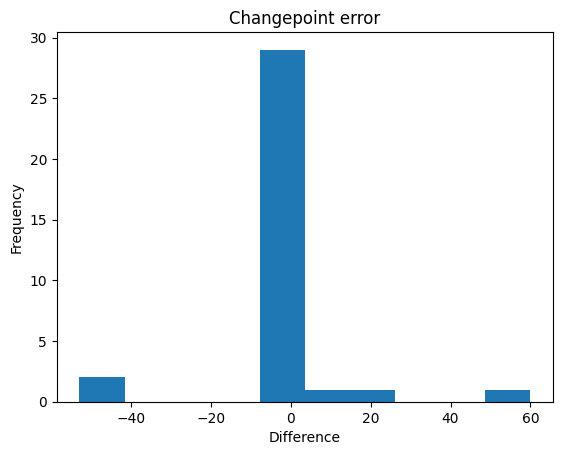

In [13]:
# For the cases where the underlying data has a changepoint and the model has correctly identified
# there is a changepoint, calculate the error in the changepoint position
changepoint_error = [changepoint_pred[i] - changepoint_true[i] for i in range(n_experiments) \
                    if changepoint_pred[i] is not None and changepoint_true[i] is not None]

plt.hist(changepoint_error)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Changepoint error')
plt.show()

## Potentially delayed samples

The delay will be assumed to be Poisson distributed.

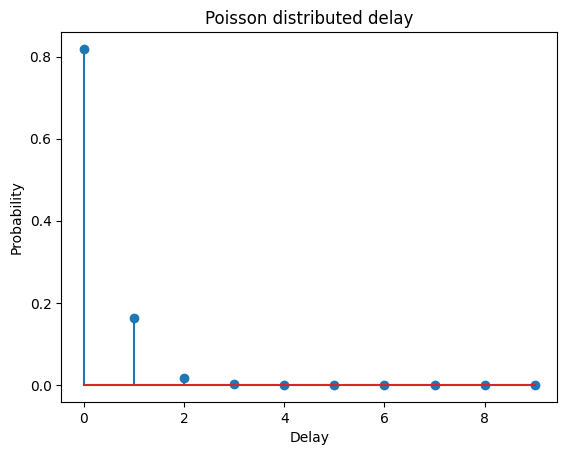

In [14]:
x = np.arange(0, 10)
y = stats.poisson.pmf(x, 0.2)
plt.stem(x, y)
plt.xlabel('Delay')
plt.ylabel('Probability')
plt.title('Poisson distributed delay')
plt.show()

In [15]:
def time_delay_samples(x: np.ndarray, mu: float):
    """Time delay samples with a Poisson distribution."""

    assert mu > 0

    # Use the inverse survival function to determine the number of extra indices required
    extra_indices = int(stats.poisson.isf(0.001, mu))
    
    # Create an array that can hold the delayed values
    n = len(x)
    result = np.zeros(n + extra_indices)

    for i in range(n):
        for _ in range(int(x[i])):
            delay = stats.poisson.rvs(mu=mu)

            # New index given the delay
            j = i + delay

            if j < (n + extra_indices):
                result[j] += 1

    return result

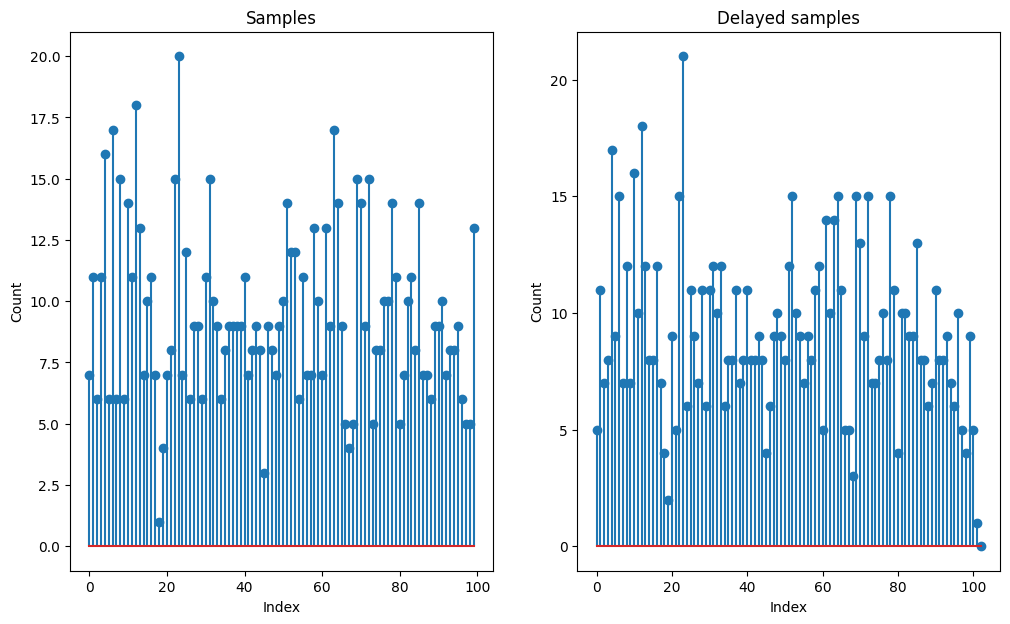

In [16]:
time_delayed_x = time_delay_samples(data['samples'], 0.2)

fig = plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.stem(data['samples'])
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Samples')

plt.subplot(1,2,2)
plt.stem(time_delayed_x)
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Delayed samples')
plt.show()

In [17]:
n_experiments = 100
mu_delay = 0.2  # Mean of the Poisson distribution for the delay

y_true = []
y_pred_no_delay = []
y_pred_delay = []

changepoint_true = []
changepoint_pred_no_delay = []
changepoint_pred_delay = []

for _ in tqdm(range(n_experiments)):
    # Generate a dataset that may contain a changepoint
    data = generate_changepoint_data(100, 2, 10, 0.5)
    y_true.append(data['number_of_changepoints'])
    changepoint_true.append(data['position'])

    # Changepoint detection without delaying samples
    m = select_model(data['samples'])
    y_pred_no_delay.append(m['number_of_changepoints'])
    changepoint_pred_no_delay.append(m['position'])

    # Time delay samples and then perform model selection
    time_delayed_x = time_delay_samples(data['samples'], mu_delay)
    m = select_model(time_delayed_x)
    y_pred_delay.append(m['number_of_changepoints'])
    changepoint_pred_delay.append(m['position'])

100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


In [18]:
metrics.confusion_matrix(y_true, y_pred_no_delay)

array([[46,  4],
       [15, 35]])

In [19]:
metrics.confusion_matrix(y_true, y_pred_delay)

array([[ 0, 50],
       [ 0, 50]])

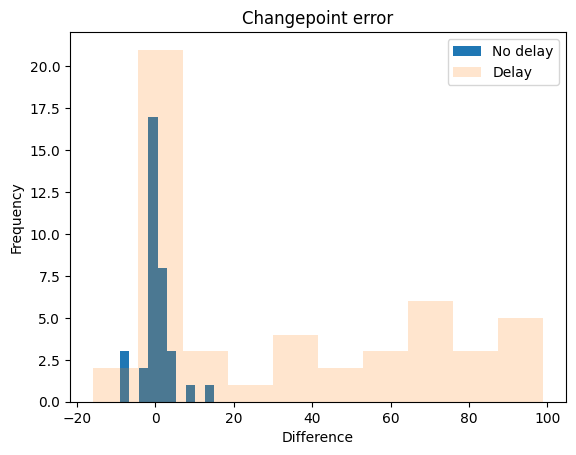

In [20]:
changepoint_error_no_delay = [changepoint_pred_no_delay[i] - changepoint_true[i] for i in range(n_experiments) \
                              if changepoint_pred_no_delay[i] is not None and changepoint_true[i] is not None]

changepoint_error_delay = [changepoint_pred_delay[i] - changepoint_true[i] for i in range(n_experiments) \
                           if changepoint_pred_delay[i] is not None and changepoint_true[i] is not None]

plt.hist(changepoint_error_no_delay, label='No delay')
plt.hist(changepoint_error_delay, alpha=0.2, label='Delay')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Changepoint error')
plt.legend()
plt.show()

In [21]:
print(f"Precision with no delay / delay: {metrics.precision_score(y_true, y_pred_no_delay):.3f} / {metrics.precision_score(y_true, y_pred_delay):.3f}")
print(f"Recall with no delay / delay: {metrics.recall_score(y_true, y_pred_no_delay):.3f} / {metrics.recall_score(y_true, y_pred_delay):.3f}")
print(f"F1-score with no delay / delay: {metrics.f1_score(y_true, y_pred_no_delay):.3f} / {metrics.f1_score(y_true, y_pred_delay):.3f}")

Precision with no delay / delay: 0.897 / 0.500
Recall with no delay / delay: 0.700 / 1.000
F1-score with no delay / delay: 0.787 / 0.667


Just using the delayed data (i.e. not applying any corrections) has dropped the performance of the detector.

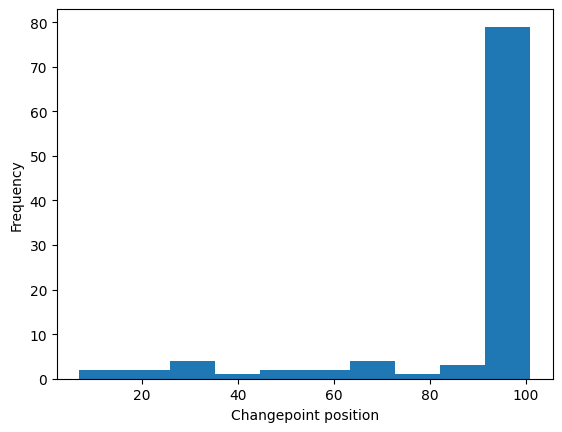

In [22]:
plt.hist([c for c in changepoint_pred_delay if c is not None])
plt.xlabel('Changepoint position')
plt.ylabel('Frequency')
plt.show()

The changepoint detector is incorrectly biased towards a changepoint occurring at the end where the padding is.

## Generate delayed samples without edge effects

In [23]:
def generate_changepoint_data_with_delays(n: int, a: float, b: float, p: float, mu: float):
    """Generate data with n points that may contain a changepoint with probability p."""

    assert n > 3
    assert 0 < a < b
    assert 0 <= p <= 1
    assert mu > 0

    # Means of the Poisson distributions
    lambda0 = np.random.uniform(low=a, high=b)
    lambda1 = np.random.uniform(low=a, high=b)

    # Determine the amount of padding required
    padding = int(stats.poisson.isf(0.0001, mu))

    # Total number of samples to generate
    n_samples = n + 2 * padding

    # Samples from the two Poisson distributions
    x0 = np.random.poisson(lam=lambda0, size=n_samples)
    x1 = np.random.poisson(lam=lambda1, size=n_samples)

    # Is there a single changepoint?
    one_changepoint = np.random.uniform() < p

    # Generate the (undelayed) samples
    if one_changepoint:
        changepoint_position = np.random.randint(padding+1, padding+n-1)
        x = np.zeros(n_samples)
        x[:changepoint_position] = x0[:changepoint_position]
        x[changepoint_position:] = x1[changepoint_position:]
    else:        
        x = x0
        changepoint_position = None

    # Time delay the samples
    x_delayed = np.zeros(n_samples)
    for i in range(n_samples):
        for _ in range(int(x[i])):
            delay = stats.poisson.rvs(mu=mu)

            # New index given the delay
            j = i + delay

            if 0 <= j < n_samples:
                x_delayed[j] += 1
    
    data = {
        "samples_undelayed": x[padding:n+padding],
        "samples_delayed": x_delayed[padding:n+padding],
        "number_of_changepoints": 1 if one_changepoint else 0,
        "position": changepoint_position - padding if one_changepoint else None,
    }

    assert len(data['samples_delayed']) == n
    assert len(data['samples_undelayed']) == n
    assert data['number_of_changepoints'] in [0,1]
    if data['number_of_changepoints'] == 1:
        assert 0 <= data['position'] < n
    else:
        assert data['position'] is None

    return data

In [24]:
data = generate_changepoint_data_with_delays(100, 2, 10, 0.5, 0.2)
data

{'samples_undelayed': array([11,  7,  5, 11,  5,  6, 10,  4,  8,  9,  5, 10,  6,  6,  6,  7,  6,
         8,  4,  6,  5, 12,  4, 11,  7,  8,  5,  6,  7,  8,  8,  8, 11,  6,
         5,  5, 10,  7,  7,  7,  5,  6,  9,  6,  6,  5,  5,  7,  5,  6,  4,
         6,  7,  8,  7, 10,  5,  6,  3,  8,  6, 10, 13,  9,  4, 10,  9,  6,
         4,  9,  3,  5,  9,  7,  9,  6, 11,  8,  6,  3,  6,  8,  7,  8,  8,
         3,  4,  7,  3,  6,  4, 13,  9,  9,  6,  2,  6, 13,  5, 13]),
 'samples_delayed': array([10., 11.,  4., 10.,  6.,  5., 10.,  5.,  9.,  8.,  4., 10.,  6.,
         7.,  5.,  8.,  5.,  8.,  6.,  4.,  7.,  9.,  6.,  8.,  8.,  9.,
         6.,  5.,  9.,  7.,  8.,  8., 12.,  4.,  6.,  5.,  9.,  6.,  9.,
         6.,  6.,  6.,  7.,  7.,  7.,  6.,  5.,  4.,  7.,  6.,  5.,  5.,
         6., 10.,  4., 12.,  5.,  7.,  3.,  6.,  5., 11., 11.,  9.,  5.,
        11., 10.,  7.,  4.,  9.,  3.,  5.,  7.,  7., 10.,  6., 11.,  7.,
         7.,  2.,  4., 11.,  8.,  7.,  8.,  4.,  4.,  6.,  3.,  7.,  3.,

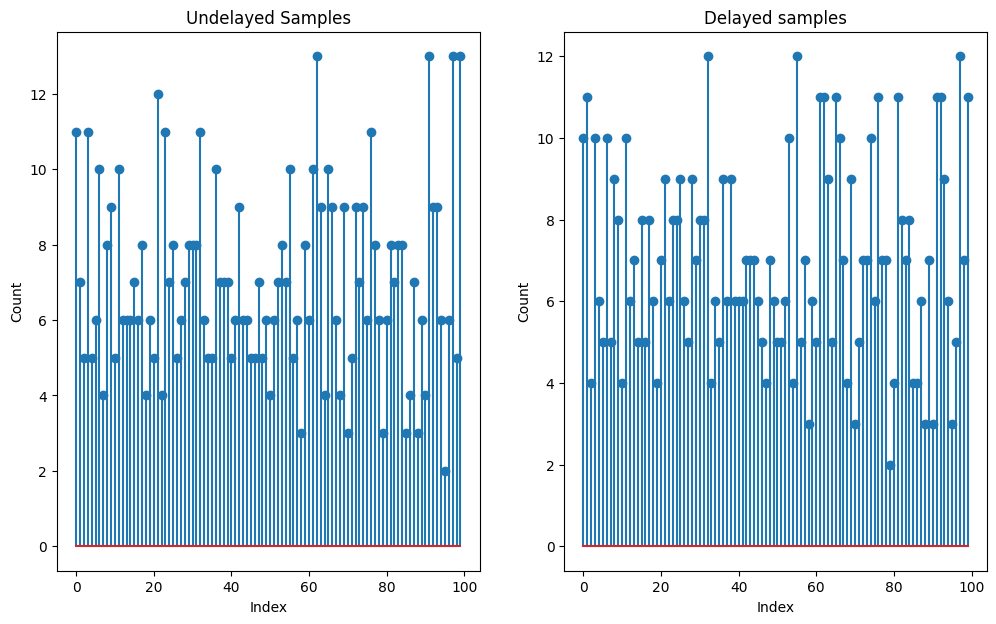

In [25]:
fig = plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.stem(data['samples_undelayed'])
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Undelayed Samples')

plt.subplot(1,2,2)
plt.stem(data['samples_delayed'])
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Delayed samples')
plt.show()

In [26]:
n_experiments = 500
y_true = []
y_pred = []
y_pred_delayed = []
changepoint_true = []  # Actual changepoint
changepoint_pred = []  # Predicted changepoint
changepoint_pred_delayed = []  # Predicted changepoint from delayed samples

for _ in tqdm(range(n_experiments)):
    data = generate_changepoint_data_with_delays(100, 2, 10, 0.5, 0.2)
    y_true.append(data['number_of_changepoints'])
    changepoint_true.append(data['position'])

    m = select_model(data['samples_undelayed'])
    y_pred.append(m['number_of_changepoints'])
    changepoint_pred.append(m['position'])

    m = select_model(data['samples_delayed'])
    y_pred_delayed.append(m['number_of_changepoints'])
    changepoint_pred_delayed.append(m['position'])

100%|██████████| 500/500 [04:34<00:00,  1.82it/s]


In [27]:
metrics.confusion_matrix(y_true, y_pred)

array([[244,  16],
       [ 84, 156]])

In [28]:
metrics.confusion_matrix(y_true, y_pred_delayed)

array([[243,  17],
       [ 86, 154]])

In [29]:
print(f"Precision with no delay / delay: {metrics.precision_score(y_true, y_pred):.3f} / {metrics.precision_score(y_true, y_pred_delayed):.3f}")
print(f"Recall with no delay / delay: {metrics.recall_score(y_true, y_pred):.3f} / {metrics.recall_score(y_true, y_pred_delayed):.3f}")
print(f"F1-score with no delay / delay: {metrics.f1_score(y_true, y_pred):.3f} / {metrics.f1_score(y_true, y_pred_delayed):.3f}")

Precision with no delay / delay: 0.907 / 0.901
Recall with no delay / delay: 0.650 / 0.642
F1-score with no delay / delay: 0.757 / 0.749


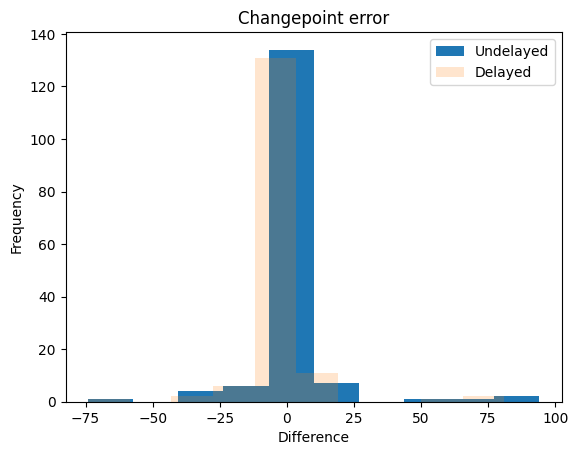

In [30]:
changepoint_error = [changepoint_pred[i] - changepoint_true[i] for i in range(n_experiments) \
                    if changepoint_pred[i] is not None and changepoint_true[i] is not None]

changepoint_error_delayed = [changepoint_pred_delayed[i] - changepoint_true[i] for i in range(n_experiments) \
                             if changepoint_pred_delayed[i] is not None and changepoint_true[i] is not None]

plt.hist(changepoint_error, label='Undelayed')
plt.hist(changepoint_error_delayed, alpha=0.2, label='Delayed')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Changepoint error')
plt.legend()
plt.show()

In [31]:
print(f"MSE without delay: {(np.array(changepoint_error)**2).mean():.2f}")
print(f"MSE with delay: {(np.array(changepoint_error_delayed)**2).mean():.2f}")

MSE without delay: 225.73
MSE with delay: 179.42


### Try to undelay the samples

To begin with, the samples will be undelayed assuming the mean of the Poisson distribution of the delay is known exactly.

In [32]:
def remove_trailing_zeros(x: np.ndarray) -> np.ndarray:
    while x[-1] == 0:
        x = x[:-1]
    return x

In [33]:
def undelay(x: np.ndarray, mu: float):

    n = len(x)
    result = np.zeros(n)

    for i in range(n):
        for _ in range(int(x[i])):
            delay = stats.poisson.rvs(mu=mu)

            # New index given the delay
            j = i - delay

            if j >= 0:
                result[j] += 1

    # Remove the zeros at the end of the result to avoid an erroneous changepoint
    # being detected there
    return remove_trailing_zeros(result)

In [34]:
def select_model_undelayed(x: np.ndarray, mu: float, n_runs: int):
    """Select the model when the data is 'undelayed'."""

    assert mu > 0
    assert n_runs > 0

    best_model = np.zeros(n_runs)
    positions = []

    for i in range(n_runs):
        undelayed_sample = undelay(x, mu)
        m = select_model(undelayed_sample)
        best_model[i] = m['number_of_changepoints']
        if m['number_of_changepoints'] == 1:
            positions.append(m['position'])

    if sum(best_model) > (n_runs/2):
        return {"number_of_changepoints": 1,
                "position": np.mean(positions)}
    
    return {"number_of_changepoints": 0, "position": None}

In [35]:
n_experiments = 100
mu_delay = 0.2

y_true = []
y_pred_delayed = []
y_pred_undelayed = []

changepoint_true = []  # Actual changepoint
changepoint_pred_delayed = []  # Predicted changepoint from delayed samples
changepoint_pred_undelayed = []  # Predicted changepoint using the undelay algorithm

for _ in tqdm(range(n_experiments)):
    # Generate a dataset
    data = generate_changepoint_data_with_delays(100, 2, 10, 0.5, mu_delay)
    y_true.append(data['number_of_changepoints'])
    changepoint_true.append(data['position'])

    # Perform changepoint detection on the delayed samples
    m = select_model(data['samples_delayed'])
    y_pred_delayed.append(m['number_of_changepoints'])
    changepoint_pred_delayed.append(m['position'])

    # Try to undelay the delayed samples and then perform change detection
    m = select_model_undelayed(data['samples_delayed'], mu_delay, 100)
    y_pred_undelayed.append(m['number_of_changepoints'])
    changepoint_pred_undelayed.append(m['position'])

100%|██████████| 100/100 [1:19:07<00:00, 47.47s/it]


In [36]:
print(f"F1-score using the delayed samples: {metrics.f1_score(y_true, y_pred_delayed):.3f}")
metrics.confusion_matrix(y_true, y_pred_delayed)

F1-score using the delayed samples: 0.706


array([[45,  3],
       [22, 30]])

In [37]:
print(f"F1-score using the undelayed samples: {metrics.f1_score(y_true, y_pred_undelayed):.3f}")
metrics.confusion_matrix(y_true, y_pred_undelayed)

F1-score using the undelayed samples: 0.714


array([[46,  2],
       [22, 30]])

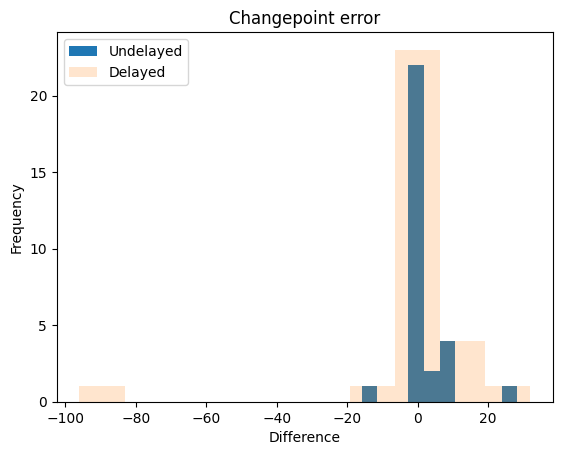

In [38]:
changepoint_error_undelayed = [changepoint_pred_undelayed[i] - changepoint_true[i] for i in range(n_experiments) \
                               if changepoint_pred_undelayed[i] is not None and changepoint_true[i] is not None]

changepoint_error_delayed = [changepoint_pred_delayed[i] - changepoint_true[i] for i in range(n_experiments) \
                             if changepoint_pred_delayed[i] is not None and changepoint_true[i] is not None]

plt.hist(changepoint_error_undelayed, label='Undelayed')
plt.hist(changepoint_error_delayed, alpha=0.2, label='Delayed')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Changepoint error')
plt.legend()
plt.show()

In [39]:
print(f"MSE delayed: {(np.array(changepoint_error_delayed)**2).mean():.2f}")
print(f"MSE undelay: {(np.array(changepoint_error_undelayed)**2).mean():.2f}")

MSE delayed: 372.10
MSE undelay: 46.21


Using a very naive approach to undelaying the samples has resulted in a lower mean squared error (MSE) in the estimated position of the changepoint.

## Bayesian approach to changepoint detection with delayed samples

Whilst the naive approach reduces the MSE between the actual changepoint position and the true changepoint position and detection of whether there is a changepoint is more calculate from an F1-score perspective, it is not viable. The problem is that the mean of the Poisson distribution of the delay must be known.

In this section, a Bayesian approach to undelay potentially delayed samples and perform changepoint detection algorithm is developed in stages.

### Estimation of the mean of a Poisson distribution

There are $N$ independent and identically distributed (IID) samples $x$ drawn from a Poisson distribution, where the mean of the Poisson distribution has a uniform prior in the range $[a,b]$.

$$
\lambda \sim \text{Uniform}(a,b)
$$

and

$$
x_i \sim \text{Poisson}(\lambda)
$$

The likelihood of the samples given the Poisson distribution mean $\lambda$ is given by

$$
p(x|\lambda) = \prod_{i=0}^{N-1} p(x_i | \lambda)
$$

The probability of the mean of the Poisson distribution given the samples and the prior probability is $\lambda$ is given by Bayes' theorem:

$$
p(\lambda | x) = \frac{p(x, \lambda)}{p(x)} = \frac{p(x | \lambda) p(\lambda)}{p(x)}
$$

The joint distribution is given by

$$
p(x, \lambda) = p(x | \lambda) p(\lambda) = 
\begin{cases}
 \frac{1}{b-a} \prod_{i=0}^{N-1} e^{-\lambda} \frac{\lambda^{x_i}}{x_i !} & a \leq \lambda \leq b \\
 0             & \text{otherwise} \\
\end{cases}
$$

The log of the joint distribution when $a \leq \lambda \leq b$ is given by

$$
\begin{align*}
\ln p(x, \lambda) &= \ln \frac{1}{b-a} + \sum_{i=0}^{N-1} \ln e^{-\lambda} \frac{\lambda^{x_i}}{x_i !} \\
    &= -\ln (b-a) + \sum_{i=0}^{N-1} (-\lambda + x_i \ln \lambda - \ln x_i!) \\
    &= -\ln (b-a) - N \lambda + \ln \lambda \sum_{i=0}^{N-1} x_i -  \sum_{i=0}^{N-1} \ln x_i! \\
\end{align*}
$$

In [57]:
def log_likelihood(x: np.ndarray, lam: float, a: float, b:float):
    if lam < a or lam > b:
        return -np.inf
    
    N = len(x)
    return -np.log(b-a) - N*lam + np.log(lam)*np.sum(x) - np.sum(np.log(scipy.special.factorial(x)))

In [58]:
# Parameters of the prior
a = 1
b = 3
lam_true = np.random.uniform(a,b)
N = 20

# Generate samples from a Poisson distribution
x = np.random.poisson(lam_true, size=N)

In [59]:
lam = [(b-a)/2]
q = np.exp(log_likelihood(x, lam[0], a, b))
sigma = 0.1
burnin = 200

for i in range(1, 10000):
    lam_candidate = np.random.normal(lam[i-1], sigma)
    q_candidate = np.exp(log_likelihood(x, lam_candidate, a, b))

    acceptance_prob = min(1, q_candidate/q)
    u = np.random.uniform(0, 1)

    if u > acceptance_prob:
        lam.append(lam[i-1])  # Reject the proposal
    else:
        lam.append(lam_candidate)  # Accept the proposal
        q = q_candidate

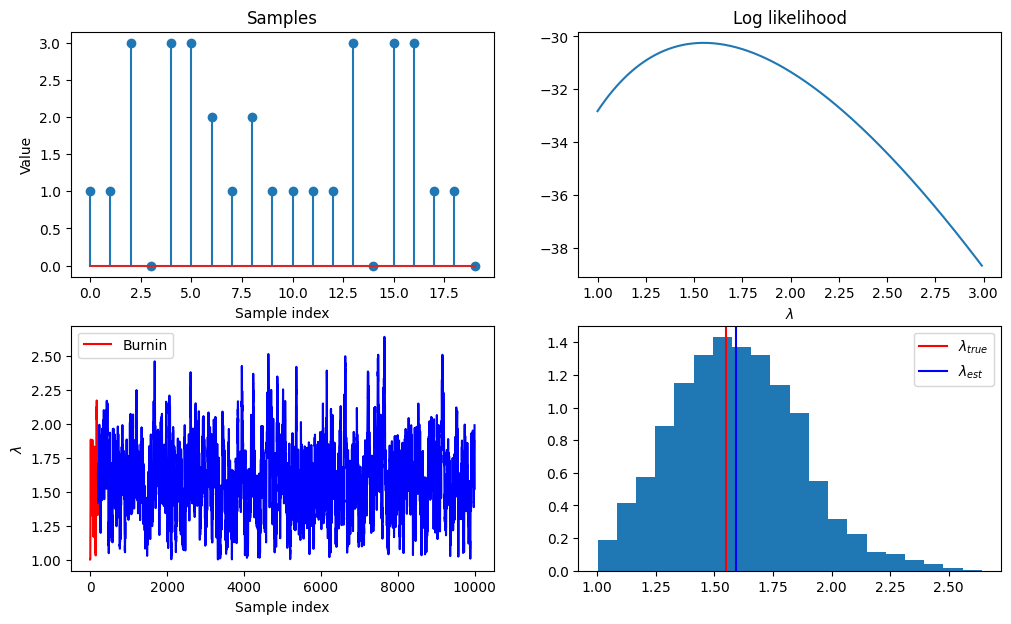

In [62]:
fig = plt.figure(figsize=(12,7))

plt.subplot(2, 2, 1)
plt.stem(x)
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Samples')

plt.subplot(2, 2, 2)
plt.plot(np.arange(a,b,0.01), [log_likelihood(x, l, a, b) for l in np.arange(a,b,0.01)])
plt.xlabel('$\\lambda$')
plt.title('Log likelihood')

plt.subplot(2, 2, 3)
plt.plot(range(burnin), lam[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(lam)), lam[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$\\lambda$')
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(lam[burnin:], bins=20, density=True)
plt.axvline(x=np.mean(x), color='r', label='$\\lambda_{true}$')
plt.axvline(x=np.mean(lam[burnin:]), color='b', label='$\\lambda_{est}$')
plt.legend()
plt.show()

### Changepoint detection assuming Poisson distributed samples

The mean of the Poisson distribution before the changepoint is $\lambda_0 \sim \text{Uniform}(a,b)$ and $\lambda_1 \sim \text{Uniform}(a,b)$ after the changepoint. The index at which the changepoint occurs is $
j \sim \text{Uniform}(1,N-2)$.

The likelihood of the data $x$ given the means of the Poisson distributions $\lambda_0, \lambda_1$ and the changepoint $j$ is given by

$$
p(x | \lambda_0, \lambda_1, j) = \Big[ \prod_{i=0}^{j-1} p(x_i|\lambda_0) \Big] \Big[ \prod_{i=j}^{N-1} p(x_i|\lambda_1) \Big].
$$

The posterior probability is found using Bayes' theorem:

$$
p(\lambda_0, \lambda_1, j | x) = \frac{p(x, \lambda_0, \lambda_1, j)}{p(x)} = \frac{p(x | \lambda_0, \lambda_1, j) p(\lambda_0) p(\lambda_1) p(j)}{p(x)}.
$$

The joint probability is given by:

$$
p(x, \lambda_0, \lambda_1, j) = 
\begin{cases}
  \Big[ \prod_{i=0}^{j-1} p(x_i|\lambda_0) \Big] \Big[ \prod_{i=j}^{N-1} p(x_i|\lambda_1) \Big] & a \leq \lambda_0, \lambda_1 \leq b, 1 \leq j \leq N-1  \\
  0 & \text{otherwise} \\
\end{cases}
$$

In the case where the joint probability is non-zero:

$$
\begin{align*}
\ln p(x, \lambda_0, \lambda_1, j) &= \sum_{i=0}^{j-1} \ln p(x_i|\lambda_0) + \sum_{i=j}^{N-1} p(x_i|\lambda_1) - 2 \ln (b-a) - \ln (N-2) \\
  &= \sum_{i=0}^{j-1} \Big( -\lambda_0 + x_i \ln \lambda_0 - \ln x_i! \Big) + \sum_{i=j}^{N-1} \Big( -\lambda_1 + x_i \ln \lambda_1 - \ln x_i! \Big) - 2 \ln (b-a) - \ln (N-1) \\
  &= -j \lambda_0 + \ln \lambda_0 \sum_{i=0}^{j-1} x_i - \sum_{i=0}^{j-1} \ln x_i! - (N-1-j) \lambda_1 + \ln \lambda_1 \sum_{i=j}^{N-1} x_i - \sum_{i=j}^{N-1} \ln x_i! - 2 \ln (b-a) - \ln (N-1) \\
  &= -j \lambda_0 + \ln \lambda_0 \sum_{i=0}^{j-1} x_i - (N-1-j) \lambda_1 + \ln \lambda_1 \sum_{i=j}^{N-1} x_i - \sum_{i=0}^{N-1} \ln x_i! - 2 \ln (b-a) - \ln (N-1) \\
\end{align*}
$$

In [132]:
def log_likelihood(x, lambda_0, lambda_1, j, a, b):

    N = len(x)

    if lambda_0 < a or lambda_0 > b or \
        lambda_1 < a or lambda_1 > b or \
        j < 0 or j >= N:
        return -np.inf

    return -j*lambda_0 + np.log(lambda_0)*np.sum(x[:j]) - \
        (N-1-j)*lambda_1 + np.log(lambda_1)*np.sum(x[j:]) - \
        np.sum(np.log(scipy.special.factorial(x))) - \
        2*np.log(b-a) - np.log(N-1)

In [150]:
a = 1
b = 3
N = 50

lambda_0 = np.random.uniform(a, b)  # Mean before the changepoint
lambda_1 = np.random.uniform(a, b)  # Mean after the changepoint
j = np.random.randint(1, N-1)       # Changepoint index

x = np.zeros(N)
x[:j] = np.random.poisson(lam=lambda_0, size=j)    # Before the changepoint
x[j:] = np.random.poisson(lam=lambda_1, size=N-j)  # After the changepoint

In [153]:
# Find a suitable starting point for the MCMC chain
ll = [(j_prime, log_likelihood(x, np.mean(x[:j_prime]), np.mean(x[j_prime:]), j_prime, a, b)) \
      for j_prime in range(1,N)]
j_est = [max(ll, key=lambda x: x[1])[0]]
lam_0 = [np.mean(x[:j_est[0]])]
lam_1 = [np.mean(x[j_est[0]:])]

lam_0 = [(b-a)/2]
lam_1 = [(b-a)/2]
j_est = [round(N/2)]

q = np.exp(log_likelihood(x, lam_0[0], lam_1[0], j_est[0], a, b))
sigma_lambda = 0.1
sigma_j = 0.5
burnin = 10000

for i in range(1, 100000):
    lam_0_candidate = np.random.normal(lam_0[i-1], sigma_lambda)
    lam_1_candidate = np.random.normal(lam_1[i-1], sigma_lambda)
    j_candidate = round(np.random.normal(j_est[i-1], sigma_j))

    q_candidate = np.exp(log_likelihood(x, lam_0_candidate, lam_1_candidate, j_candidate, a, b))

    acceptance_prob = min(1, q_candidate/q)
    u = np.random.uniform(0, 1)

    if u > acceptance_prob:
        lam_0.append(lam_0[i-1])  # Reject the proposal
        lam_1.append(lam_1[i-1])
        j_est.append(j_est[i-1])
    else:
        lam_0.append(lam_0_candidate)  # Accept the proposal
        lam_1.append(lam_1_candidate)
        j_est.append(j_candidate)
        q = q_candidate

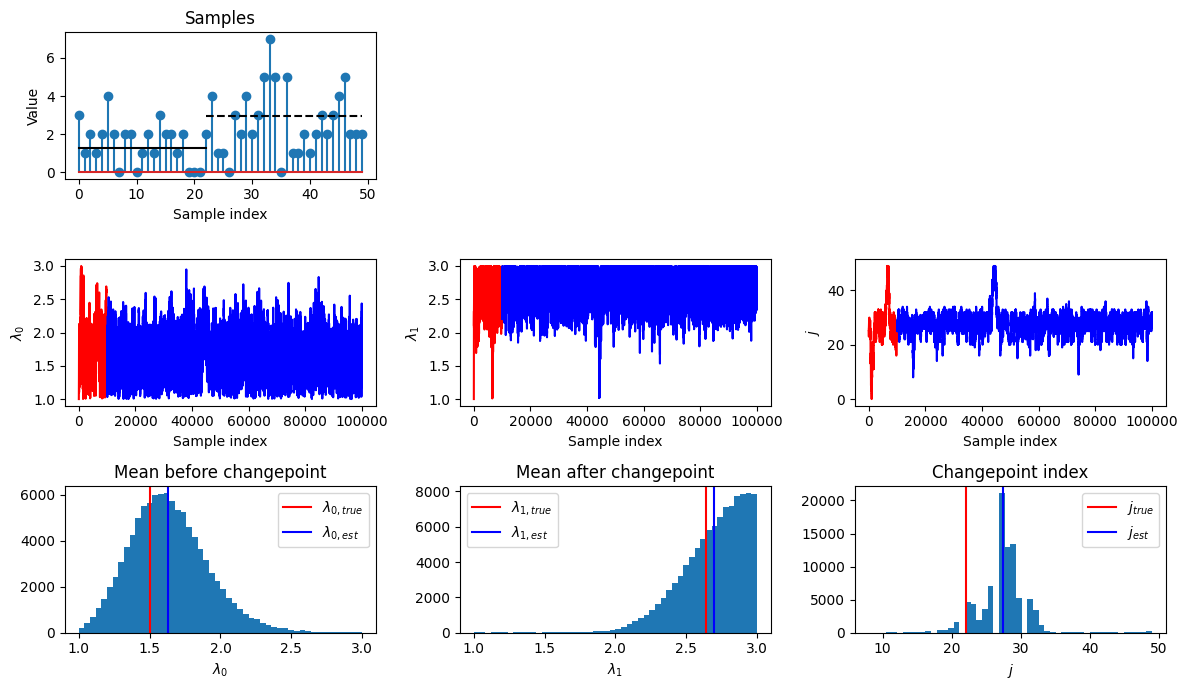

In [160]:
fig = plt.figure(figsize=(12,7))

plt.subplot(3, 3, 1)
plt.stem(x)
plt.plot(np.arange(0, j+1), lambda_0*np.ones(j+1), '-k', label='$\\lambda_0$')
plt.plot(np.arange(j, N), lambda_1*np.ones(N - j), '--k', label='$\\lambda_1$')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Samples')

plt.subplot(3, 3, 4)
plt.plot(range(burnin), lam_0[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(lam_0)), lam_0[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$\\lambda_0$')

plt.subplot(3, 3, 5)
plt.plot(range(burnin), lam_1[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(lam_1)), lam_1[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$\\lambda_1$')

plt.subplot(3, 3, 6)
plt.plot(range(burnin), j_est[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(j_est)), j_est[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$j$')

plt.subplot(3, 3, 7)
plt.hist(lam_0, bins=50)
plt.axvline(x=np.mean(x[:j]), color='r', label='$\\lambda_{0,true}$')
plt.axvline(x=np.mean(lam_0[burnin:]), color='b', label='$\\lambda_{0,est}$')
plt.xlabel('$\\lambda_0$')
plt.title('Mean before changepoint')
plt.legend()

plt.subplot(3, 3, 8)
plt.hist(lam_1, bins=50)
plt.axvline(x=np.mean(x[j:]), color='r', label='$\\lambda_{1,true}$')
plt.axvline(x=np.mean(lam_1[burnin:]), color='b', label='$\\lambda_{1,est}$')
plt.xlabel('$\\lambda_1$')
plt.title('Mean after changepoint')
plt.legend()

plt.subplot(3, 3, 9)
plt.hist(j_est[burnin:], bins=50)
plt.axvline(x=j, color='r', label='$j_{true}$')
plt.axvline(x=np.mean(j_est[burnin:]), color='b', label='$j_{est}$')
plt.xlabel('$j$')
plt.title('Changepoint index')
plt.legend()

plt.tight_layout()
plt.show()

### Estimate of the mean of a Poisson distribution where the samples have a constant offset

Suppose the observed samples $y_i$ have a constant but known offset $\delta$.

$$
\lambda \sim \text{Uniform}(a,b)
$$

$$
x_i \sim \text{Poisson}(\lambda)
$$

$$
\delta \sim \text{DiscreteUniform}(a_0, b_0)
$$

$$
y_i = x_i + \delta
$$

The probability of the samples is given by

$$
\begin{align*}
p(x | \lambda, \delta) &= \prod_{i=0}^{N-1} p(x_i | \lambda, \delta) \\
    &= \prod_{i=0}^{N-1} p(x_i - \delta | \lambda) \\
    &= \prod_{i=0}^{N-1} e^{-\lambda} \frac{\lambda^{x_i - \delta} }{(x_i - \delta)!}
\end{align*}
$$

The probability of the mean of the Poisson distribution $\lambda$ and the offset $\delta$ can be found by applying Bayes' theorem:

$$
p(\lambda, \delta | x) = \frac{p(x|\lambda, \delta) p(\lambda) p(\delta)}{p(x)}.
$$

The joint probability is given by

$$
p(x, \lambda, \delta) = \prod_{i=0}^{N-1} e^{-\lambda} \frac{\lambda^{x_i - \delta}}{(x_i - \delta)!} \frac{1}{b_0 - a_0 + 1} \frac{1}{b-a}
$$

if $a \leq \lambda \leq b$ and $a_0 \leq \delta \leq b_0$. The log of the joint probability where $a \leq \lambda \leq b$ and $a_0 \leq \delta \leq b_0$ is

$$
\begin{align*}
\ln p(x, \lambda, \delta) &= \sum_{i=0}^{N-1} \Big[ -\lambda + (x_i + \delta) \ln \lambda - \ln (x_i - \delta)! \Big] - \ln (b_0 - a_0 + 1) - \ln (b-a) \\
    &= -N(\lambda + \delta \ln \lambda) + \sum_{i=0}^{N-1} x_i \ln \lambda - \sum_{i=0}^{N-1} \ln (x_i - \delta)! - \ln (b_0 - a_0 + 1) - \ln (b-a) \\
\end{align*}
$$

In [201]:
a, b = 1, 3
a0, b0 = 2, 5
N = 20

delta = np.random.randint(a0, b0)
lam = np.random.uniform(a, b)
x = np.random.poisson(lam=lam, size=N)
y = x + delta

In [202]:
def log_likelihood(x, lam, delta, a, b, a0, b0):
    if lam < a or lam > b or delta < a0 or delta > b0:
        return -np.inf
    
    if np.any(x-delta < 0):
        return -np.inf

    N = len(x)
    return -N*(lam + delta*np.log(lam)) + np.log(lam)*np.sum(x) - \
        np.sum(np.log(scipy.special.factorial(x-delta))) - np.log(b0-a0+1) - np.log(b-a)

In [212]:
delta_est = [a0]
lam_est = [(b0-a0)/2]
q = np.exp(log_likelihood(y, lam_est[0], delta_est[0], a, b, a0, b0))

sigma_delta = 0.5
sigma_lam = 0.1

burnin = 5000
for i in range(20000):
    delta_candidate = round(np.random.normal(delta_est[i-1], sigma_delta))
    lam_candidate = np.random.normal(lam_est[i-1], sigma_lam)

    q_candidate = np.exp(log_likelihood(y, lam_candidate, delta_candidate, a, b, a0, b0))

    acceptance_prob = min(1, q_candidate/q)
    u = np.random.uniform(0, 1)

    if u > acceptance_prob:
        delta_est.append(delta_est[i-1])  # Reject the proposal
        lam_est.append(lam_est[i-1])
    else:
        delta_est.append(delta_candidate)  # Accept the proposal
        lam_est.append(lam_candidate)
        q = q_candidate

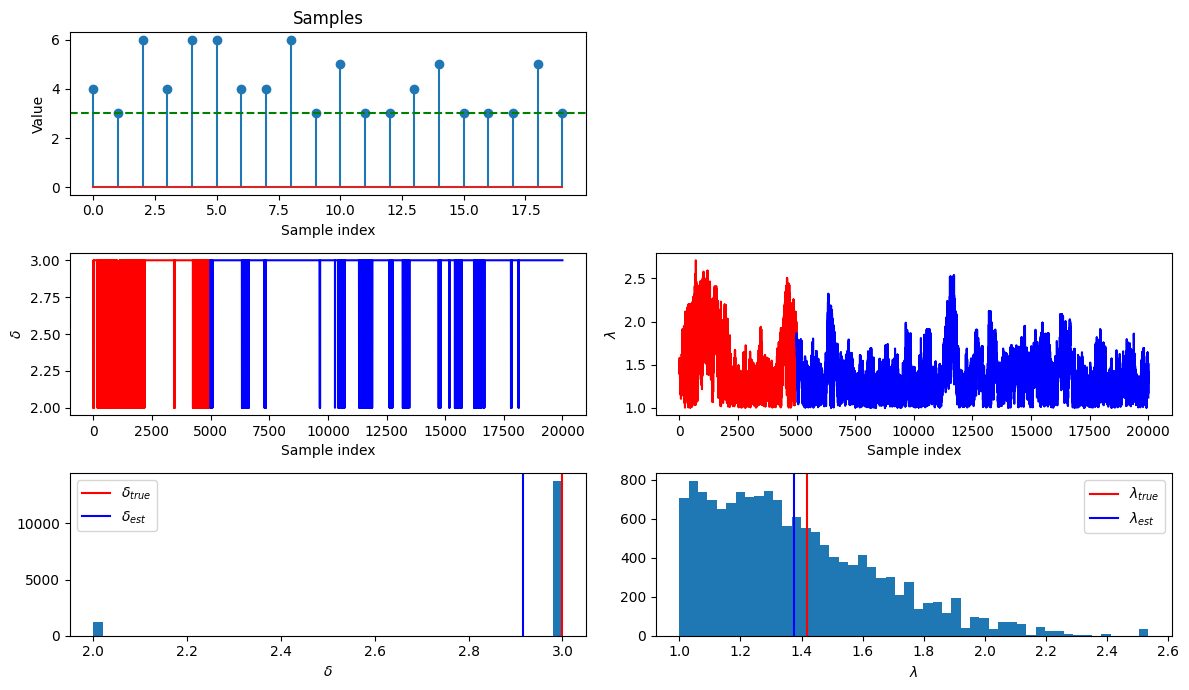

In [213]:
fig = plt.figure(figsize=(12,7))

plt.subplot(3, 2, 1)
plt.stem(y)
plt.axhline(y=delta, color='g', linestyle='--')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Samples')

plt.subplot(3, 2, 3)
plt.plot(range(burnin), delta_est[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(delta_est)), delta_est[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$\\delta$')

plt.subplot(3, 2, 4)
plt.plot(range(burnin), lam_est[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(lam_est)), lam_est[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$\\lambda$')

plt.subplot(3, 2, 5)
plt.hist(delta_est[burnin:], bins=50)
plt.axvline(x=delta, label='$\\delta_{true}$', color='r')
plt.axvline(x=np.mean(delta_est[burnin:]), label='$\\delta_{est}$', color='b')
plt.xlabel('$\\delta$')
plt.legend()

plt.subplot(3, 2, 6)
plt.hist(lam_est[burnin:], bins=50)
plt.axvline(x=lam, label='$\\lambda_{true}$', color='r')
plt.axvline(x=np.mean(lam_est[burnin:]), label='$\\lambda_{est}$', color='b')
plt.xlabel('$\\lambda$')
plt.legend()

plt.tight_layout()
plt.show()

### Estimation of the mean of a Poisson distribution with a single delayed sample and a known shift

Suppose a single sample is delayed by 1 time index, but the sample index is unknown.

$$
\lambda \sim \text{Uniform}(a,b)
$$

$$
j \sim \text{DiscreteUniform}(0, N-2)
$$

$$
x_i
\begin{cases}
= 0 & \text{if } i = j \\
\sim \text{Poisson}(\lambda) + \text{Poisson}(\lambda) & \text{if } i = j + 1 \\
\sim \text{Poisson}(\lambda) & \text{otherwise}
\end{cases}
$$

In [46]:
a, b = 1, 3
lam = np.random.uniform(a, b)
N = 20

j = np.random.randint(0, N-2)
x = np.random.poisson(lam=lam, size=N)
lam_actual = np.mean(x)
x[j+1] = x[j] + x[j+1]
x[j] = 0

In [69]:
def log_likelihood(x, lam, j, a, b):
    if lam < a or lam > b:
        return -np.inf
    
    if x[j] != 0:
        return -np.inf

    ll = 0
    for i in range(len(x)):
        if i == j:
            continue
        elif i == j + 1:
            ll += np.log(stats.poisson.pmf(x[i], 2*lam))
        else:
            ll += np.log(stats.poisson.pmf(x[i], lam))

    return ll

In [70]:
j_est = [random.choice(np.where(x == 0)[0])]
lam_est = [np.mean(x)]
q = np.exp(log_likelihood(x, lam_est[0], j_est[0], a, b))

sigma_lam = 0.1

burnin = 5000
for i in range(20000):
    j_candidate = random.choice(np.where(x == 0)[0])
    lam_candidate = np.random.normal(lam_est[i-1], sigma_lam)

    q_candidate = np.exp(log_likelihood(x, lam_candidate, j_candidate, a, b))

    acceptance_prob = min(1, q_candidate/q)
    u = np.random.uniform(0, 1)

    if u > acceptance_prob:
        j_est.append(j_est[i-1])  # Reject the proposal
        lam_est.append(lam_est[i-1])
    else:
        j_est.append(j_candidate)  # Accept the proposal
        lam_est.append(lam_candidate)
        q = q_candidate

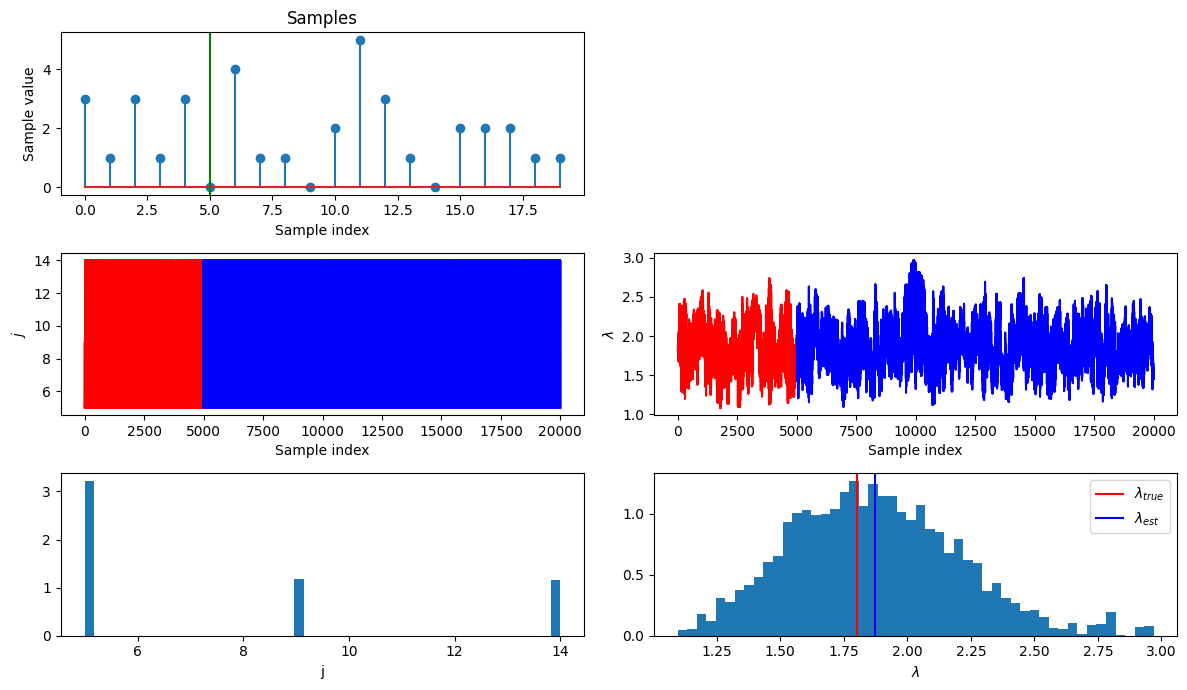

In [71]:
plt.figure(figsize=(12, 7))

plt.subplot(3, 2, 1)
plt.stem(x)
plt.axvline(x=j, color='g')
plt.xlabel('Sample index')
plt.ylabel('Sample value')
plt.title('Samples')

plt.subplot(3,2,3)
plt.plot(range(burnin), j_est[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(j_est)), j_est[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$j$')

plt.subplot(3,2,4)
plt.plot(range(burnin), lam_est[:burnin], 'r', label='Burnin')
plt.plot(range(burnin, len(lam_est)), lam_est[burnin:], 'b')
plt.xlabel('Sample index')
plt.ylabel('$\\lambda$')

plt.subplot(3,2,5)
plt.hist(j_est[burnin:], density=True, bins=50)
plt.xlabel('j')

plt.subplot(3,2,6)
plt.hist(lam_est[burnin:], density=True, bins=50)
plt.axvline(x=lam_actual, color='r', label='$\\lambda_{true}$')
plt.axvline(x=np.mean(lam_est[burnin:]), color='b', label='$\\lambda_{est}$')
plt.xlabel('$\\lambda$')
plt.legend()

plt.tight_layout()
plt.show()

### Estimation of the mean of a Poisson distribution with a single delayed sample and unknown shift

Suppose a single sample is delayed by some time index.

$$
\lambda \sim \text{Uniform}(a,b)
$$

$$
j \sim \text{DiscreteUniform}(0, N-1)
$$

The unknown shift is

$$
s \sim \text{DiscreteUniform}(a_0, b_0).
$$

$$
x_i
\begin{cases}
= 0 & \text{if } i = j \\
\sim \text{Poisson}(\lambda) + \text{Poisson}(\lambda) & \text{if } i = j + s \\
\sim \text{Poisson}(\lambda) & \text{otherwise}
\end{cases}
$$

In [114]:
a, b = 1, 3
a0, b0 = 1, 5
lam = np.random.uniform(a, b)
s = np.random.randint(a0, b0)
N = 20

j = np.random.randint(0, N-b0)  # Ensure the shift occurs within the window
x = np.random.poisson(lam=lam, size=N)
lam_actual = np.mean(x)
x[j+1] = x[j] + x[j+s]
x[j] = 0

In [115]:
def log_likelihood(x, lam, j, s, a, b, a0, b0):
    if lam < a or lam > b or s < a0 or s > b0:
        return -np.inf
    
    if x[j] != 0:
        return -np.inf

    ll = 0
    for i in range(len(x)):
        if i == j:
            continue
        elif i == j + s:
            ll += np.log(stats.poisson.pmf(x[i], 2*lam))
        else:
            ll += np.log(stats.poisson.pmf(x[i], lam))

    return ll

In [116]:
j_est = [random.choice(np.where(x == 0)[0])]
s_est = [1]
lam_est = [np.mean(x)]
q = np.exp(log_likelihood(x, lam_est[0], j_est[0], s_est[0], a, b, a0, b0))

sigma_s = 0.5
sigma_lam = 0.1

burnin = 5000
for i in range(20000):
    j_candidate = random.choice(np.where(x == 0)[0])
    s_candidate = round(np.random.normal(s_est[i-1], sigma_s))
    lam_candidate = np.random.normal(lam_est[i-1], sigma_lam)

    q_candidate = np.exp(log_likelihood(x, lam_candidate, j_candidate, s_candidate, a, b, a0, b0))

    acceptance_prob = min(1, q_candidate/q)
    u = np.random.uniform(0, 1)

    if u > acceptance_prob:
        j_est.append(j_est[i-1])  # Reject the proposal
        s_est.append(s_est[i-1])
        lam_est.append(lam_est[i-1])
    else:
        j_est.append(j_candidate)  # Accept the proposal
        s_est.append(s_candidate)
        lam_est.append(lam_candidate)
        q = q_candidate

In [56]:
def plot_samples(samples: np.ndarray, burnin: int, label: str):
    plt.plot(range(burnin), samples[:burnin], 'r', label='Burnin')
    plt.plot(range(burnin, len(samples)), samples[burnin:], 'b')
    plt.xlabel('Sample index')
    plt.ylabel(label)

In [57]:
def plot_hist(samples: np.ndarray, burnin: int, label: str, actual):
    plt.hist(samples[burnin:], density=True, bins=50)
    plt.axvline(x=actual, color='r', label=f"${label}_{{true}}$")
    plt.axvline(x=np.mean(samples[burnin:]), color='b', label=f"${label}_{{est}}$")
    plt.xlabel(f'${label}$')
    plt.legend()

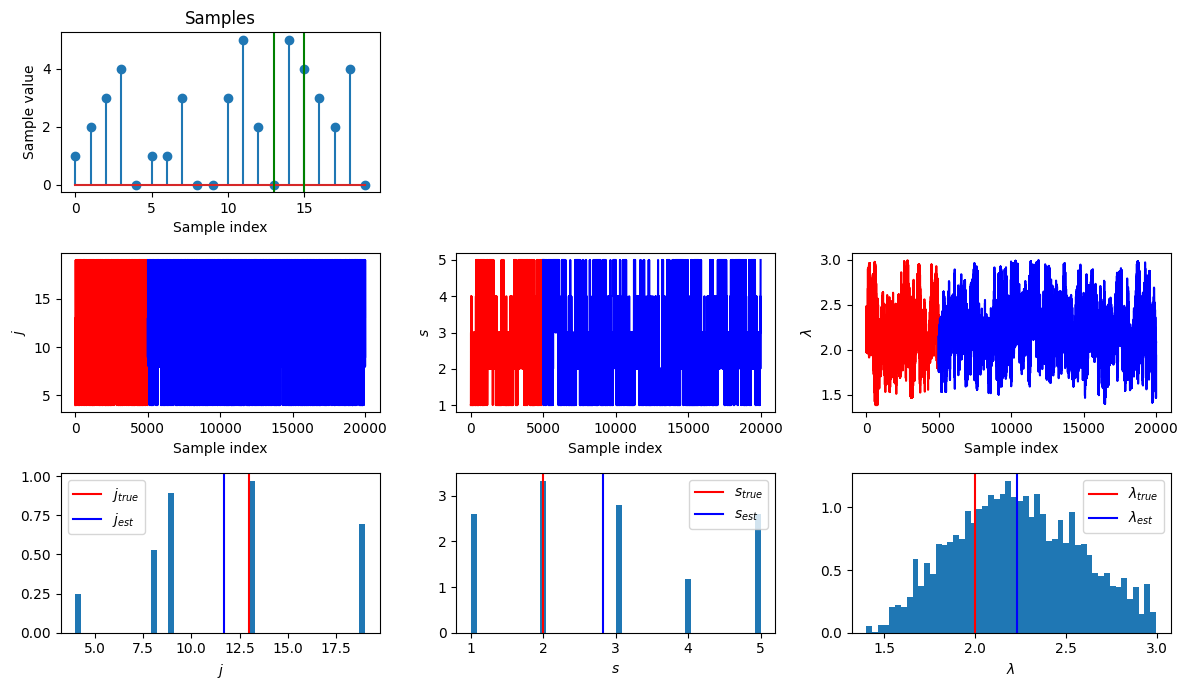

In [119]:
plt.figure(figsize=(12, 7))

plt.subplot(3, 3, 1)
plt.stem(x)
plt.axvline(x=j, color='g', label='j')
plt.axvline(x=j+s, color='g', label='j+s')
plt.xlabel('Sample index')
plt.ylabel('Sample value')
plt.title('Samples')

plt.subplot(3,3,4)
plot_samples(j_est, burnin, '$j$')

plt.subplot(3,3,5)
plot_samples(s_est, burnin, '$s$')

plt.subplot(3,3,6)
plot_samples(lam_est, burnin, '$\\lambda$')

plt.subplot(3,3,7)
plot_hist(j_est, burnin, 'j', j)

plt.subplot(3,3,8)
plot_hist(s_est, burnin, 's', s)

plt.subplot(3,3,9)
plot_hist(lam_est, burnin, '\\lambda', lam)

plt.tight_layout()
plt.show()

### Model estimation with multiple delayed samples

In [134]:
a, b = 1, 3  # Min and max value of the mean of the Poisson distribution
lam = np.random.uniform(a, b)  # Mean of the Poisson distribution
c = 0.4 
p = np.random.uniform(0, c)  # Probability of observed events being delayed
N = 20  # Number of days
s_max = 3  # Maximum shift in days

x = np.zeros(N)
d = np.zeros(N)
s = np.zeros(N, dtype=int)
n = np.zeros(N)

for i in range(N):

    # Are the events of day i delayed?
    d[i] = np.random.binomial(n=1, p=p)

    if d[i] == 0:
        observed_index = i
    else:
        s[i] = np.random.randint(1, s_max+1)  # Shift on day i
        observed_index = int(s[i] + i)
        
        if observed_index >= N:
            observed_index = i
            s[i] = 0
            d[i] = 0
    
    n[observed_index] += 1
    x[observed_index] += np.random.poisson(lam=lam)

assert np.sum(n) == N
assert all([s[i] == 0 for i in range(N) if d[i] == 0])  # Undelayed samples shouldn't have a shift
assert all([s[i] != 0 for i in range(N) if d[i] == 1])  # Delayed samples should have a shift

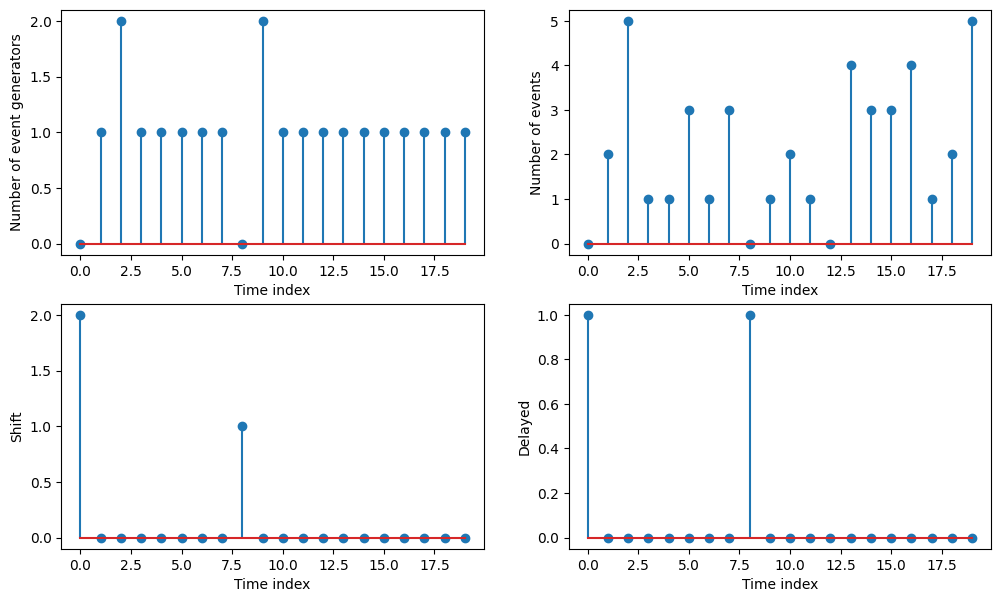

In [135]:
plt.figure(figsize=(12,7))

plt.subplot(2, 2, 1)
plt.stem(n)
plt.xlabel('Time index')
plt.ylabel('Number of event generators')

plt.subplot(2, 2, 2)
plt.stem(x)
plt.xlabel('Time index')
plt.ylabel('Number of events')

plt.subplot(2, 2, 3)
plt.stem(s)
plt.xlabel('Time index')
plt.ylabel('Shift')

plt.subplot(2, 2, 4)
plt.stem(d)
plt.xlabel('Time index')
plt.ylabel('Delayed')

plt.show()

In [136]:
def log_likelihood(x, lam, p, d, s, a, b, c, s_max):

    # Lambda = mean of the Poisson distribution
    if lam < a or lam > b:
        return -np.inf

    # p = probability of an event on a given day
    if p < 0 or p > c:
        return -np.inf
    
    # N = number of days
    N = len(x)

    # Observed number of event generators on each day
    n = np.zeros(N)
    for i in range(N):
        if s[i] < 0 or s[i] > s_max:
            return -np.inf  # Shift is invalid
        
        if d[i] == 0:
            n[i] = 1  # No delay
        else:
            observed_index = int(i + s[i])  # Delay
            if observed_index < N:
                n[observed_index] += 1

    # Log likelihood
    ll = 0
    for i in range(N):
        if n[i] == 0:
            if x[i] != 0:
                return -np.inf
            else:
                ll += 0
        else:
            ll += np.log(stats.poisson.pmf(x[i], n[i]*lam))

    return ll + np.log(stats.binom.pmf(k=np.sum(d), n=len(x), p=p))

In [137]:
lam_est = [np.mean(x)]
p_est = [c/2]
d_est = [np.zeros(N)]
s_est = [np.zeros(N)]

q = np.exp(log_likelihood(x, lam_est[0], p_est[0], d_est[0], s_est[0], a, b, c, s_max))

sigma_lam = 0.1
sigma_p = 0.1
burnin = 10000

for i in range(100000):
    lam_candidate = np.random.normal(lam_est[i-1], sigma_lam)
    p_candidate = np.random.normal(p_est[i-1], sigma_p)

    # The options for s are:
    # 0. Remove an existing delay
    # 1. Change an existing delay
    # 2. Add a new delay
    s_candidate = np.copy(s_est[i-1])
    option = np.random.randint(0, 3)
    delayed_indices = [i for i in range(N) if s_candidate[i] > 0]

    if option == 0 and len(delayed_indices) > 0:
        idx = random.choice(delayed_indices)
        s_candidate[idx] = 0
    elif option == 1 and len(delayed_indices) > 0:
        idx = random.choice(delayed_indices)
        original_delay = s_candidate[idx]
        while s_candidate[idx] == original_delay:
            s_candidate[idx] = np.random.randint(1, s_max+1)
    elif option == 2 and len(delayed_indices) != N:
        undelayed_indices = list(set(range(N)).difference(set(delayed_indices)))
        idx = random.choice(undelayed_indices)
        s_candidate[idx] = np.random.randint(1, s_max+1)

    d_candidate = np.array([1 if s_candidate[i] > 0 else 0 for i in range(N)])

    # Check that only a single delay has changed at most
    n_shifted_previously = np.sum([se > 0 for se in s_est[i-1]])
    n_shifted_estimate = np.sum([sc > 0 for sc in s_candidate])
    assert abs(n_shifted_previously - n_shifted_estimate) <= 1

    q_candidate = np.exp(log_likelihood(x, lam_candidate, p_candidate, d_candidate, s_candidate, a, b, c, s_max))

    acceptance_prob = min(1, q_candidate/q)
    u = np.random.uniform(0, 1)

    if u > acceptance_prob:
        # Reject the proposal
        lam_est.append(lam_est[i-1])
        p_est.append(p_est[i-1])
        d_est.append(d_est[i-1])
        s_est.append(s_est[i-1])
    else:
        # Accept the proposal
        lam_est.append(lam_candidate)
        p_est.append(p_candidate)
        d_est.append(d_candidate)
        s_est.append(s_candidate)
        q = q_candidate
    

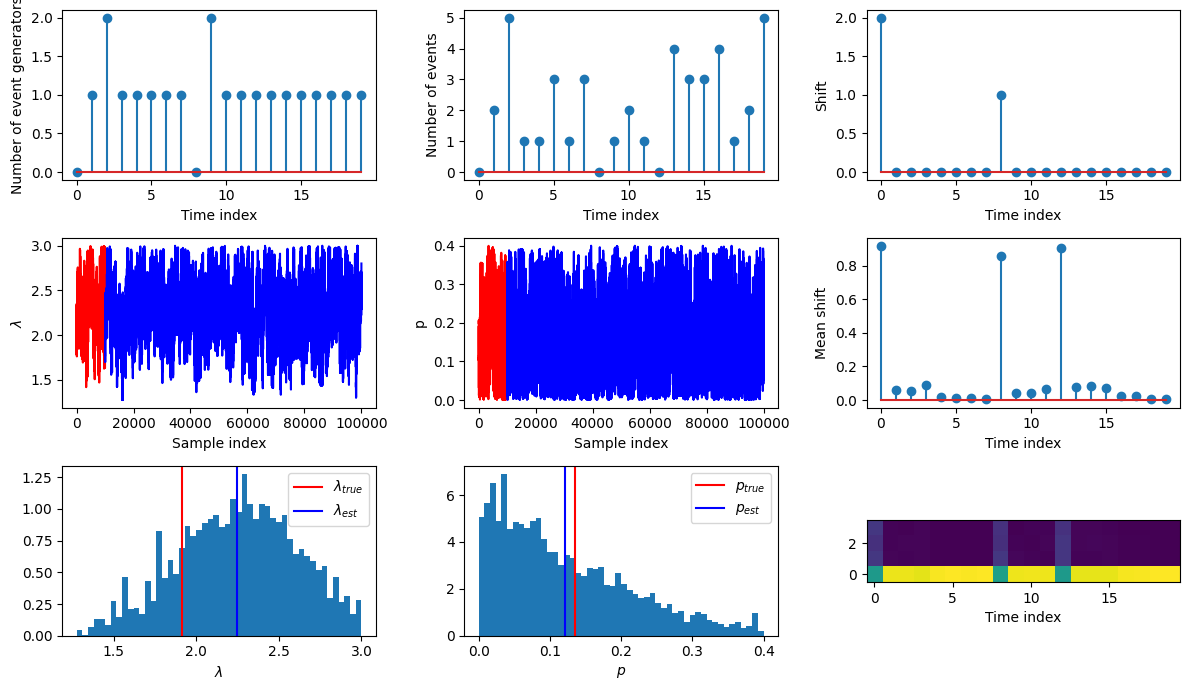

In [139]:
plt.figure(figsize=(12, 7))

plt.subplot(3, 3, 1)
plt.stem(n)
plt.xlabel('Time index')
plt.ylabel('Number of event generators')

plt.subplot(3, 3, 2)
plt.stem(x)
plt.xlabel('Time index')
plt.ylabel('Number of events')

plt.subplot(3, 3, 3)
plt.stem(s)
plt.xlabel('Time index')
plt.ylabel('Shift')

plt.subplot(3, 3, 4)
plot_samples(lam_est, burnin, '$\\lambda$')

plt.subplot(3, 3, 5)
plot_samples(p_est, burnin, 'p')

m = np.zeros((s_max+1, N))
s_est_post_burnin = np.array(s_est)[burnin:]
for i in range(s_max+1):
    for j in range(N):
        m[i,j] = np.where(s_est_post_burnin[:,j] == i)[0].shape[0]

m = m / m.sum(axis=0)

plt.subplot(3, 3, 6)
plt.stem(np.mean(s_est_post_burnin, axis=0))
plt.xlabel('Time index')
plt.ylabel('Mean shift')

plt.subplot(3, 3, 7)
plot_hist(lam_est, burnin, '\\lambda', lam)

plt.subplot(3, 3, 8)
plot_hist(p_est, burnin, 'p', p)

plt.subplot(3, 3, 9)
plt.imshow(m, origin='lower')
plt.xlabel('Time index')

plt.tight_layout()
plt.show()

### Model estimation with multiple delayed samples and a changepoint


In [238]:
a, b = 1, 3                     # Min and max value of the mean of the Poisson distribution
lam0 = np.random.uniform(a, b)  # Mean of the Poisson distribution before the changepoint
lam1 = np.random.uniform(a, b)  # Mean of the Poisson distribution after the changepoint
j = np.random.randint(1,N-2)    # Index of the changepoint

c = 0.4                         # Maximum probability of an event being delayed
p = np.random.uniform(0, c)     # Probability of observed events being delayed

N = 20                          # Number of days
s_max = 3                       # Maximum shift in days

x = np.zeros(N)                 # Number of events on each day
d = np.zeros(N)                 # Events of day i are delayed or not
s = np.zeros(N, dtype=int)      # Shift if events on day i are delayed
n = np.zeros(N)                 # Number of event generators on each day

for i in range(N):

    # Are the events of day i delayed?
    d[i] = np.random.binomial(n=1, p=p)

    if d[i] == 0:
        observed_index = i
    else:
        s[i] = np.random.randint(1, s_max+1)  # Shift on day i
        observed_index = int(s[i] + i)
        
        if observed_index >= N:
            observed_index = i
            s[i] = 0
            d[i] = 0
    
    n[observed_index] += 1

    if i < j:
        # Before the changepoint
        x[observed_index] += np.random.poisson(lam=lam0)
    else:
        # After the changepoint
        x[observed_index] += np.random.poisson(lam=lam1)

assert np.sum(n) == N
assert all([s[i] == 0 for i in range(N) if d[i] == 0])  # Undelayed samples shouldn't have a shift
assert all([s[i] != 0 for i in range(N) if d[i] == 1])  # Delayed samples should have a shift

In [239]:
def log_likelihood(x, j, lam0, lam1, p, d, s, a, b, c, s_max):

    # Lambda = mean of the Poisson distribution
    if lam0 < a or lam0 > b or lam1 < a or lam1 > b:
        return -np.inf

    # p = probability of an event on a given day
    if p < 0 or p > c:
        return -np.inf

    # N = number of days
    N = len(x)

    # j = index of the changepoint
    if j < 0 or j >= N:
        return -np.inf
    
    # Observed number of event generators on each day
    n_before = np.zeros(N)
    n_after = np.zeros(N)
    for i in range(N):
        if s[i] < 0 or s[i] > s_max:
            return -np.inf  # Shift is invalid
        
        if d[i] == 0:
            # No delay
            if i < j:
                n_before[i] = 1 
            else:
                n_after[i] = 1
        else:
            observed_index = int(i + s[i])  # Delay
            if observed_index >= N:
                continue
        
            if i < j:
                n_before[observed_index] += 1
            else:
                n_after[observed_index] += 1

    # Log likelihood
    ll = 0
    for i in range(N):
        if n_before[i] + n_after[i] == 0:
            if x[i] != 0:
                return -np.inf
            else:
                ll += 0
        else:
            mu = n_before[i]*lam0 + n_after[i]*lam1
            ll += np.log(stats.poisson.pmf(x[i], mu))

    # Probability that the number of samples have a delay
    p_delayed = stats.binom.pmf(k=np.sum(d), n=len(x), p=p)
    if p_delayed == 0:
        return -np.inf

    return ll + np.log(p_delayed)

In [240]:
lam0_est = [np.mean(x)]
lam1_est = [np.mean(x)]
j_est = [round(N/2)]
p_est = [c/2]
d_est = [np.zeros(N)]
s_est = [np.zeros(N)]

q = np.exp(log_likelihood(x, j_est[0], lam0_est[0], lam1_est[0], p_est[0], d_est[0], s_est[0], a, b, c, s_max))
assert not np.isinf(q) and q > 0

sigma_lam = 0.1
sigma_p = 0.1
burnin = 100000

for i in range(500000):
    # Perturb the means of the Poisson distributions before and after the changepoint
    lam0_candidate = np.random.normal(lam0_est[i-1], sigma_lam)
    lam1_candidate = np.random.normal(lam1_est[i-1], sigma_lam)

    # Potentially shift the changepoint position and constrain to lie in the range [0, N-1]
    j_candidate = min(N-1,max(0,round(np.random.normal(j_est[i-1], 0.7))))

    # Perturb the probability of a delay occurring at a given time index
    p_candidate = np.random.normal(p_est[i-1], sigma_p)

    # The options for s are:
    # 0. Remove an existing delay
    # 1. Change an existing delay
    # 2. Add a new delay
    s_candidate = np.copy(s_est[i-1])
    option = np.random.randint(0, 3)
    delayed_indices = [i for i in range(N) if s_candidate[i] > 0]

    if option == 0 and len(delayed_indices) > 0:
        idx = random.choice(delayed_indices)
        s_candidate[idx] = 0
    elif option == 1 and len(delayed_indices) > 0:
        idx = random.choice(delayed_indices)
        original_delay = s_candidate[idx]
        while s_candidate[idx] == original_delay:
            s_candidate[idx] = np.random.randint(1, s_max+1)
    elif option == 2 and len(delayed_indices) != N:
        undelayed_indices = list(set(range(N)).difference(set(delayed_indices)))
        idx = random.choice(undelayed_indices)
        s_candidate[idx] = np.random.randint(1, s_max+1)

    d_candidate = np.array([1 if s_candidate[i] > 0 else 0 for i in range(N)])

    # Check that only a single delay has changed at most
    n_shifted_previously = np.sum([se > 0 for se in s_est[i-1]])
    n_shifted_estimate = np.sum([sc > 0 for sc in s_candidate])
    assert abs(n_shifted_previously - n_shifted_estimate) <= 1

    q_candidate = np.exp(log_likelihood(x, j_candidate, 
                                        lam0_candidate, lam1_candidate, 
                                        p_candidate, d_candidate, s_candidate, 
                                        a, b, c, s_max))

    acceptance_prob = min(1, q_candidate/q)
    u = np.random.uniform(0, 1)

    if u > acceptance_prob:
        # Reject the proposal
        lam0_est.append(lam0_est[i-1])
        lam1_est.append(lam1_est[i-1])
        j_est.append(j_est[i-1])
        p_est.append(p_est[i-1])
        d_est.append(d_est[i-1])
        s_est.append(s_est[i-1])
    else:
        # Accept the proposal
        lam0_est.append(lam0_candidate)
        lam1_est.append(lam1_candidate)
        j_est.append(j_candidate)
        p_est.append(p_candidate)
        d_est.append(d_candidate)
        s_est.append(s_candidate)
        q = q_candidate

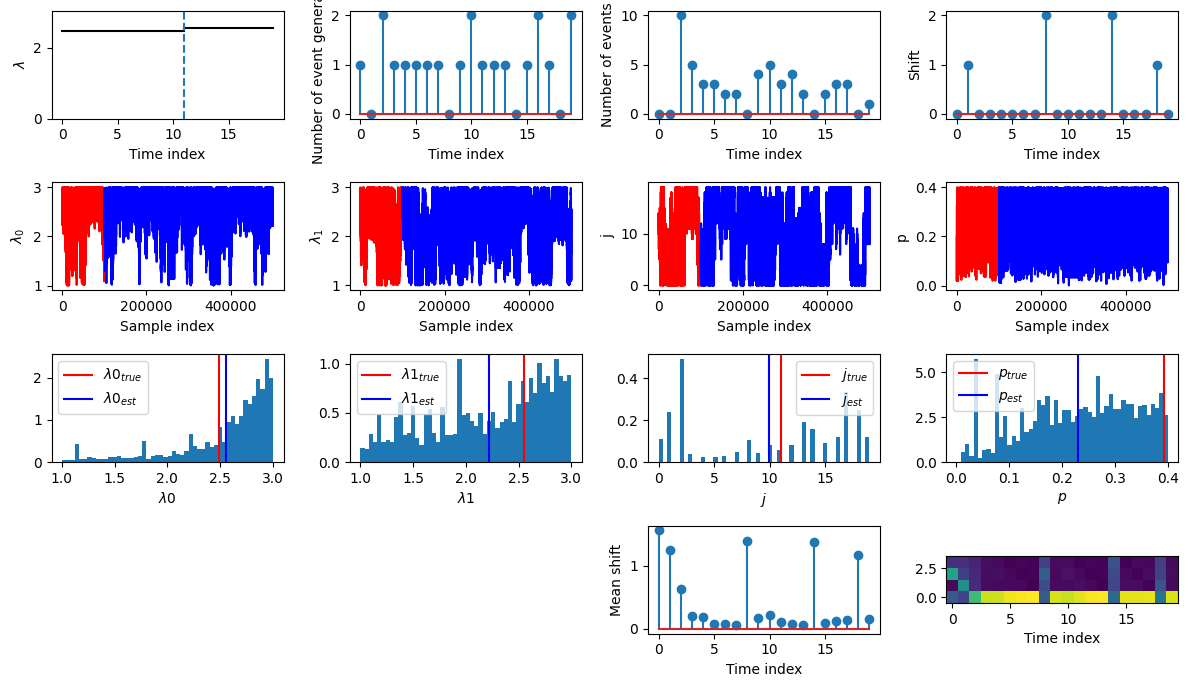

In [241]:
plt.figure(figsize=(12, 7))

plt.subplot(4, 4, 1)
plt.plot(range(j+1), lam0*np.ones(j+1), '-k')
plt.plot(range(j,N), lam1*np.ones(N-j), '-k')
plt.axvline(x=j, linestyle='--')
plt.ylim([0, max(lam0, lam1)+0.5])
plt.xlabel('Time index')
plt.ylabel('$\\lambda$')

plt.subplot(4, 4, 2)
plt.stem(n)
plt.xlabel('Time index')
plt.ylabel('Number of event generators')

plt.subplot(4, 4, 3)
plt.stem(x)
plt.xlabel('Time index')
plt.ylabel('Number of events')

plt.subplot(4, 4, 4)
plt.stem(s)
plt.xlabel('Time index')
plt.ylabel('Shift')

plt.subplot(4, 4, 5)
plot_samples(lam0_est, burnin, '$\\lambda_0$')

plt.subplot(4, 4, 6)
plot_samples(lam1_est, burnin, '$\\lambda_1$')

plt.subplot(4, 4, 7)
plot_samples(j_est, burnin, 'j')

plt.subplot(4, 4, 8)
plot_samples(p_est, burnin, 'p')

plt.subplot(4, 4, 9)
plot_hist(lam0_est, burnin, f'\\lambda0', lam0)

plt.subplot(4, 4, 10)
plot_hist(lam1_est, burnin, f'\\lambda1', lam1)

plt.subplot(4, 4, 11)
plot_hist(j_est, burnin, 'j', j)

plt.subplot(4, 4, 12)
plot_hist(p_est, burnin, 'p', p)

m = np.zeros((s_max+1, N))
s_est_post_burnin = np.array(s_est)[burnin:]
for i in range(s_max+1):
    for j in range(N):
        m[i,j] = np.where(s_est_post_burnin[:,j] == i)[0].shape[0]

m = m / m.sum(axis=0)

plt.subplot(4, 4, 15)
plt.stem(np.mean(s_est_post_burnin, axis=0))
plt.xlabel('Time index')
plt.ylabel('Mean shift')

plt.subplot(4, 4, 16)
plt.imshow(m, origin='lower')
plt.xlabel('Time index')

plt.tight_layout()
plt.show()